# THIS NOTEBOOK HAS BEEN MOVED

See https://github.com/sot/mult_stars_flag/blob/master/mult_stars_flag_impact.ipynb for the current version.  This one is left purely for the redirect for existing links in email.

# Impact of disabling multiple stars status flag filtering

Prior to uplink of the image status flag patch and subsequent operational use starting in the FEB0816 loads, if the multiple stars flag was set on the readout prior to acquisition then the star would be rejected in ACA data processing.  This would result in a failed acquisition even if the correct star was in fact acquired.

It was previously recognized that disabling the multiple stars status flag would produce a notable improvement in acquisition success rate.  However, having now created a new model of acquisition success and carried out detailed analysis, the improvement is quite substantial.  

*This provides cautious optimism of significant relief for ACA-related thermal constraints for the near future*.  

Note that this assumes that MS-filtering can be disable for guide star tracking as well.  A rather complex (and potentially incorrect) analysis has been done which demonstrates that this should not lead to unexpected safing actions (NSM or BSH).  The SSAWG and community will need to evaluate to what extent we require that analysis to be independently verified versus accepting the risk of occasional safing actions.

In [1]:
from __future__ import division
import os

import matplotlib.pyplot as plt
from astropy.table import Table
import numpy as np
from Ska.DBI import DBI

%matplotlib inline

In [2]:
# Use development version of chandra_aca which has the new acq stats fit parameters
import sys
import os
sys.path.insert(0, os.path.join(os.environ['HOME'], 'git', 'chandra_aca'))
from chandra_aca import star_probs

## Acquisition failure rate and multiple stars flag rate

Here we examine available statistics on the mean rate of the MS flag being set during guide star tracking and compares this to the model prediction of acquisition failure rate.

The time span used from 2014:180 to the present (around 2016:030 in the original iteration).  During that epoch the ACA CCD planning limit was -14 C and temperatures were relatively stable.

In [3]:
def get_trak_stats(date='2014:180'):
    """
    Get relevant info from guide star tracking statistics from Sybase database.
    This returns one record per guide star per obsid.
    """
    db = DBI(dbi='sybase', server='sybase', user='aca_read')

    stats = db.fetchall('SELECT mult_star_samples, n_samples, aoacmag_median, obsid FROM trak_stats_data '
                        'WHERE kalman_datestart > "{}" '
                        'AND aoacmag_median is not NULL'
                       .format(date))
    stats = Table(stats)
    db.conn.close()
    
    return stats

In [4]:
# Reading data from the database is slow, so cache in a FITS file
filename = 'mult_stars_flag_trak_stats.fits.gz'
if os.path.exists(filename):
    stats = Table.read(filename)
else:
    stats = get_trak_stats()
    stats.write(filename)

In [5]:
# Select only stars in range 9.0 < mag < 11.0
mags = stats['aoacmag_median']
ok = (mags > 9) & (mags < 11)
stats = stats[ok]
mags = mags[ok]

In [6]:
# Compute fraction of samples
stats['frac_ms'] = stats['mult_star_samples'] / stats['n_samples']

In [7]:
# Bin the data using mean aggregation in 0.2 mag bins
stats['mag_bin'] = np.round(mags / 0.2) * 0.2
sg = stats.group_by('mag_bin')
sgm = sg.groups.aggregate(np.mean)

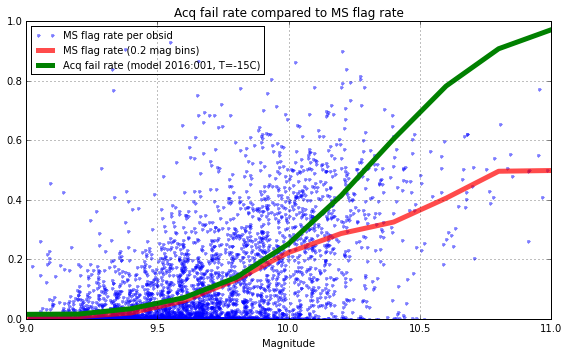

In [8]:
# Make the plot
plt.figure(1, figsize=(8, 5))
plt.clf()
randx = np.random.uniform(-0.05, 0.05, size=len(stats))
plt.plot(mags + randx, stats['frac_ms'], '.', alpha=0.5,
         label='MS flag rate per obsid')
plt.plot(sgm['mag_bin'], sgm['frac_ms'], 'r', linewidth=5, alpha=0.7,
         label='MS flag rate (0.2 mag bins)')

p_acqs = star_probs.acq_success_prob('2016:001', t_ccd=-15.0, mag=sgm['mag_bin'])
plt.plot(sgm['mag_bin'], 1 - p_acqs, 'g', linewidth=5,
         label='Acq fail rate (model 2016:001, T=-15C)')

plt.legend(loc='upper left', fontsize='medium')
plt.xlabel('Magnitude')
plt.title('Acq fail rate compared to MS flag rate')
plt.grid()
plt.tight_layout()

**Figure 1**: the plot above demonstrates that (statistically) most of the acquisition failures below 11th mag are actually due to the multiple stars flag being set.  Below about 10.0 mag nearly *all* of failures can be attributed to the MS flag.

## Acquisition failure probabilities with and without MS-flag filtering

The SOTA model for acquisition probabilities was re-fit using acquisition 
statistics that did a post-facto removal of the MS-flag filtering on board.
It was assumed that if a star were acquired at the correct position (within 5 arcsec)
and did not have ionizing radiation or saturated pixel flags set, then the
OBC *would have* identified it (aka successful acquisition).

Refitting is done in the `fit_sota_model_probit_no_ms` Jupyter notebook in this directory.

In [9]:
star_probs.__file__

'/home/aldcroft/git/chandra_aca/chandra_aca/star_probs.pyc'

In [10]:
star_probs.set_fit_pars(ms_enabled=False)

In [11]:
p_acqs_no_ms = star_probs.acq_success_prob('2016:001', t_ccd=-15.0, mag=sgm['mag_bin'])

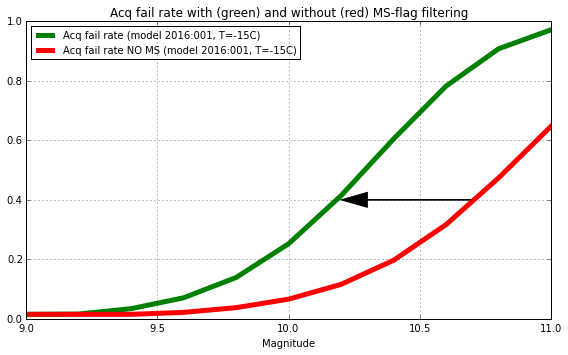

In [12]:
plt.figure(1, figsize=(8, 5))
plt.clf()
plt.plot(sgm['mag_bin'], 1 - p_acqs, 'g', linewidth=5,
         label='Acq fail rate (model 2016:001, T=-15C)')
plt.plot(sgm['mag_bin'], 1 - p_acqs_no_ms, 'r', linewidth=5,
         label='Acq fail rate NO MS (model 2016:001, T=-15C)')
plt.arrow(10.7, 0.4, -0.4, 0.0, head_width=0.05, head_length=0.1, fc='k', ec='k')
plt.legend(loc='upper left', fontsize='medium')
plt.xlabel('Magnitude')
plt.title('Acq fail rate with (green) and without (red) MS-flag filtering')
plt.grid()
plt.tight_layout();

**Figure 2** - this plot shows that disabling MS-flag filtering is similar to making the star around 0.4 mags brighter (at a given acq fail rate).  This is a **significant** improvement.

## Worst case star catalog obsid 17728 currently in the LTS for around early April
```
ra, dec, roll = 174.301751, -1.487777, 258.450000
date = 2016:092
maneuver error=30
dither = 8
```

In [13]:
# Star catalog for obsid 17728
dat_str = """
type     agasc_id   ra         dec        mag     yag      zag  notes
BOT     646185704  173.7895   -0.7888   10.571  -1.01622E-02  -1.12012E-02  a3g4
BOT     646190208  174.5589   -1.1497   10.463  -6.67958E-03   3.21581E-03  a3g4
BOT     646190528  173.8661   -1.2423   10.549  -2.67450E-03  -8.30566E-03  a3g4
BOT     646190912  173.9066   -1.5759    9.349   2.88817E-03  -6.44565E-03  a1g1
BOT     646192600  174.4886   -1.0417   10.305  -8.28102E-03   1.63611E-03  a3g3
BOT     646193600  174.1094   -2.0234   10.045   9.83073E-03  -1.41511E-03  a3g4
GUI     646189648  174.8442   -1.9800   10.757   6.52457E-03   1.09910E-02  g5
GUI     646191600  174.9020   -1.7752   10.576   2.81966E-03   1.12644E-02  g5
ACQ     646189528  174.0391   -1.7808   10.536   5.92820E-03  -3.46607E-03  a4
ACQ     646190064  174.3127   -1.3096   10.629  -3.08574E-03  -4.35447E-04  a4
"""
dat = Table.read(dat_str, format='ascii')

In [14]:
dat = dat[dat['type'] != 'GUI']
dat

type,agasc_id,ra,dec,mag,yag,zag,notes
string24,int64,float64,float64,float64,float64,float64,string32
BOT,646185704,173.7895,-0.7888,10.571,-0.0101622,-0.0112012,a3g4
BOT,646190208,174.5589,-1.1497,10.463,-0.00667958,0.00321581,a3g4
BOT,646190528,173.8661,-1.2423,10.549,-0.0026745,-0.00830566,a3g4
BOT,646190912,173.9066,-1.5759,9.349,0.00288817,-0.00644565,a1g1
BOT,646192600,174.4886,-1.0417,10.305,-0.00828102,0.00163611,a3g3
BOT,646193600,174.1094,-2.0234,10.045,0.00983073,-0.00141511,a3g4
ACQ,646189528,174.0391,-1.7808,10.536,0.0059282,-0.00346607,a4
ACQ,646190064,174.3127,-1.3096,10.629,-0.00308574,-0.000435447,a4


### MS filtering enabled (as per past operations before FEB0816)

In [15]:
# MS enabled case
star_probs.set_fit_pars(ms_enabled=True)
t_ccd = star_probs.t_ccd_warm_limit(dat['mag'], min_n_acq=(2, 0.008))[0]
print('CCD temperature must be below {:.2f} C'.format(t_ccd))

CCD temperature must be below -18.49 C


### MS filtering disabled (as per current operations)

In [16]:
# MS disabled case
star_probs.set_fit_pars(ms_enabled=False)
t_ccd = star_probs.t_ccd_warm_limit(dat['mag'], min_n_acq=(2, 0.008))[0]
print('CCD temperature must be below {:.2f} C'.format(t_ccd))

CCD temperature must be below -12.29 C


### Takeway -- acquisition seems quite feasible with MS filtering disabled

**IMPORTANT CAVEAT** - no statement made about guide star tracking.  To do this catalog we would definitely need MS filtering disabled for the whole observation.

## Run-of-the-mill synthetic constrained catalog

This represents a more typical case of a catalog that requires a temperature cooler than -14.9 C.


In [17]:
# MS enabled case
star_probs.set_fit_pars(ms_enabled=True)
mags = [10.0, 10.2, 10.2, 9.3, 10.3, 10.0, 10.0, 10.0]
t_ccd = star_probs.t_ccd_warm_limit(mags, min_n_acq=(2, 0.008))[0]
print('CCD temperature must be below {:.2f} C'.format(t_ccd))

CCD temperature must be below -14.91 C


In [18]:
# MS enabled case
star_probs.set_fit_pars(ms_enabled=False)
t_ccd = star_probs.t_ccd_warm_limit(mags, min_n_acq=(2, 0.008))[0]
print('CCD temperature must be below {:.2f} C'.format(t_ccd))

CCD temperature must be below -5.00 C
